# Posttest 5: Deep Learning untuk Klasifikasi Banknote

Pada posttest ini, kita akan membangun sebuah model *Deep Learning* sederhana menggunakan **Keras Sequential API** untuk menyelesaikan masalah **klasifikasi biner**.

**Tujuan:**
Dataset ini berisi data hasil ekstraksi fitur dari gambar uang kertas. Tujuan model kita adalah untuk memprediksi apakah sebuah uang kertas **Asli (0)** atau **Palsu (1)**.

**Instruksi yang Harus Dipenuhi:**
1.  Dataset tidak boleh sama.
2.  Minimal akurasi training 70% dan validation 70%. 
3.  Gunakan sequential model. 
4.  Buat model deep learning sederhana.

In [10]:
# Import Libraries
# Kita mengimpor semua library yang dibutuhkan di awal.
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

print(f"Pandas version: {pd.__version__}")
print(f"TensorFlow version: {tf.__version__}")

Pandas version: 2.3.2
TensorFlow version: 2.13.0


## 1. Memuat dan Mempersiapkan Data

Kita akan memuat dataset `data_banknote_authentication.csv`. Berdasarkan inspeksi kita sebelumnya, dataset ini tidak memiliki *header* (judul kolom).

Oleh karena itu, kita akan memuatnya menggunakan `header=None` dan memberikan nama kolom secara manual sesuai dokumentasi dataset:
* `variance`
* `skewness`
* `curtosis`
* `entropy`
* `class` (Target kita: 0 = Asli, 1 = Palsu)

In [11]:
# Load Dataset
# Tentukan nama kolom
column_names = ['variance', 'skewness', 'curtosis', 'entropy', 'class']

# Baca CSV, beritahu pandas tidak ada header, dan berikan nama kolom
try:
    df = pd.read_csv("data_banknote_authentication.csv", header=None, names=column_names)
    print("Dataset berhasil dimuat!")
except FileNotFoundError:
    print("Error: File 'data_banknote_authentication.csv' tidak ditemukan.")
    print("Pastikan file dataset berada di folder yang sama dengan notebook ini.")

# Tampilkan 5 data pertama untuk inspeksi
df.head()

Dataset berhasil dimuat!


,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


## 2. Inspeksi Data (EDA Sederhana)

Sebelum melatih model, kita perlu:
1.  Memeriksa tipe data (`.info()`) untuk memastikan semua fitur numerik dan tidak ada data yang hilang (*missing values*).
2.  Memeriksa distribusi kelas target (`.value_counts()`) untuk melihat apakah datanya seimbang.

In [4]:
# Inspeksi Data
print("--- Info Dataset ---")
df.info()

print("\n--- Distribusi Kelas Target (class) ---")
print(df['class'].value_counts())

--- Info Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB

--- Distribusi Kelas Target (class) ---
class
0    762
1    610
Name: count, dtype: int64


### Penjelasan Hasil Inspeksi

* **Info Dataset:** `1372 entries` (baris data), 0 *non-null* di semua kolom. Ini artinya **data kita bersih** dan tidak ada nilai yang hilang (*missing values*). Semua 4 fitur sudah dalam bentuk `float64` (angka) dan target `class` dalam bentuk `int64` (angka). Sempurna.
* **Distribusi Kelas:**
    * Kelas `0` (Asli): 762 sampel
    * Kelas `1` (Palsu): 610 sampel
    
Dataset ini cukup seimbang, jadi kita tidak perlu teknik *sampling* khusus.

## 3. Preprocessing Data

Model *Deep Learning* bekerja paling baik ketika data fitur (X) memiliki skala yang seragam. Kita akan melakukan 3 langkah:

1.  **Pemisahan Fitur (X) dan Target (y):** Kita pisahkan dataset menjadi `X` (kolom fitur) dan `y` (kolom target).
2.  **Scaling Fitur:** Kita akan menggunakan `StandardScaler` dari Scikit-learn untuk men-skala-kan `X`. Ini akan mengubah distribusi setiap fitur sehingga memiliki rata-rata 0 dan standar deviasi 1.
3.  **Split Data:** Kita bagi data menjadi 80% data latih (*training*) dan 20% data validasi (*validation*).

In [12]:
# Pisahkan Fitur dan Target
X = df.drop('class', axis=1)  # Semua kolom KECUALI 'class'
y = df['class']              # Hanya kolom 'class'

# Cell 5: Scaling Fitur
# Scaling sangat penting untuk performa model DNN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cell 6: Split Data (Training & Validation)
# test_size=0.2 berarti 20% data untuk validasi, 80% untuk training
# random_state=42 memastikan hasil split kita konsisten setiap kali dijalankan
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Bentuk X_train: {X_train.shape}")
print(f"Bentuk X_val: {X_val.shape}")

Bentuk X_train: (1097, 4)
Bentuk X_val: (275, 4)


## 4. Membangun Model Deep Learning (Sequential)

Ini adalah inti dari posttest. Kita akan memenuhi **Instruksi 3 & 4**.
Kita akan membuat model **Sequential** sederhana (DNN / MLP).

**Arsitektur Model:**
1.  **Input Layer:** Ditentukan oleh `input_shape=(4,)` di layer pertama, karena kita punya 4 fitur (variance, skewness, curtosis, entropy).
2.  **Hidden Layer 1:** `Dense` layer dengan 16 neuron dan aktivasi `relu`.
3.  **Hidden Layer 2:** `Dense` layer dengan 8 neuron dan aktivasi `relu`.
4.  **Output Layer:** `Dense` layer dengan 1 neuron dan aktivasi **`sigmoid`**.
    * Kita pakai 1 neuron karena ini klasifikasi biner (0 atau 1).
    * Kita pakai `sigmoid` karena fungsi ini akan mengeluarkan probabilitas (nilai antara 0 dan 1).

In [13]:
# Membuat Model Sequential
model = Sequential([
    # Input layer. 'input_shape=[4]' berarti kita punya 4 fitur
    Input(shape=(4,), name='Input_Layer'),
    
    # Hidden layer pertama dengan 16 neuron, aktivasi ReLU
    Dense(16, activation='relu', name='Hidden_Layer_1'),
    
    # Hidden layer kedua dengan 8 neuron, aktivasi ReLU
    Dense(8, activation='relu', name='Hidden_Layer_2'),
    
    # Output layer dengan 1 neuron, aktivasi sigmoid untuk klasifikasi biner
    Dense(1, activation='sigmoid', name='Output_Layer')
])

# Menampilkan ringkasan arsitektur model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_Layer_1 (Dense)      (None, 16)                80        
                                                                 
 Hidden_Layer_2 (Dense)      (None, 8)                 136       
                                                                 
 Output_Layer (Dense)        (None, 1)                 9         
                                                                 
Total params: 225 (900.00 Byte)
Trainable params: 225 (900.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 5. Kompilasi Model

Sebelum melatih, model perlu di-*compile*. Di sini kita menentukan:
* **`loss`:** `binary_crossentropy`. Ini adalah *loss function* standar untuk klasifikasi biner (2 kelas).
* **`optimizer`:** `adam`. Ini adalah optimizer yang paling umum digunakan dan sangat efisien.
* **`metrics`:** `['accuracy']`. Ini adalah bagian penting untuk **Instruksi 2**, kita meminta model untuk melaporkan akurasi di setiap *epoch*.

In [14]:
# Kompilasi Model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Model berhasil di-compile!")

Model berhasil di-compile!


## 6. Melatih Model

Sekarang kita latih model menggunakan `.fit()`.
* Kita latih pada `X_train` dan `y_train`.
* Kita tentukan `epochs=50`. *Epoch* adalah satu kali iterasi penuh pada seluruh data training.
* Kita tentukan `validation_data=(X_val, y_val)`. Ini memungkinkan Keras untuk menguji performa model pada data validasi di *setiap akhir epoch*.
* Hasil dari `.fit()` kita simpan di variabel `history`. Variabel ini berisi catatan *loss* dan *accuracy* dari training dan validasi di setiap *epoch*.

In [15]:
# Training Model
# Kita set verbose=1 agar bisa melihat proses training per epoch
print("Memulai proses training model...")

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    verbose=1
)

print("\nTraining selesai!")

Memulai proses training model...
Epoch 1/50
35/35 [==============================] - 2s 13ms/step - loss: 0.6986 - accuracy: 0.5014 - val_loss: 0.6428 - val_accuracy: 0.7091
Epoch 2/50
35/35 [==============================] - 0s 6ms/step - loss: 0.5936 - accuracy: 0.7657 - val_loss: 0.5559 - val_accuracy: 0.8473
Epoch 3/50
35/35 [==============================] - 0s 5ms/step - loss: 0.5086 - accuracy: 0.8952 - val_loss: 0.4781 - val_accuracy: 0.9164
Epoch 4/50
35/35 [==============================] - 0s 6ms/step - loss: 0.4320 - accuracy: 0.9307 - val_loss: 0.4076 - val_accuracy: 0.9345
Epoch 5/50
35/35 [==============================] - 0s 5ms/step - loss: 0.3603 - accuracy: 0.9371 - val_loss: 0.3382 - val_accuracy: 0.9418
Epoch 6/50
35/35 [==============================] - 0s 5ms/step - loss: 0.2916 - accuracy: 0.9517 - val_loss: 0.2706 - val_accuracy: 0.9527
Epoch 7/50
35/35 [==============================] - 0s 6ms/step - loss: 0.2263 - accuracy: 0.9617 - val_loss: 0.2052 - val_acc

## 7. Evaluasi dan Visualisasi Hasil

Ini adalah langkah terakhir untuk membuktikan **Instruksi 2 (Akurasi > 70%)**.

Kita akan membuat 2 plot:
1.  **Plot Akurasi:** Membandingkan `accuracy` (training) vs. `val_accuracy` (validation).
2.  **Plot Loss:** Membandingkan `loss` (training) vs. `val_loss` (validation).

Plot ini sangat penting untuk melihat apakah model kita *good fit*, *overfitting*, atau *underfitting*.

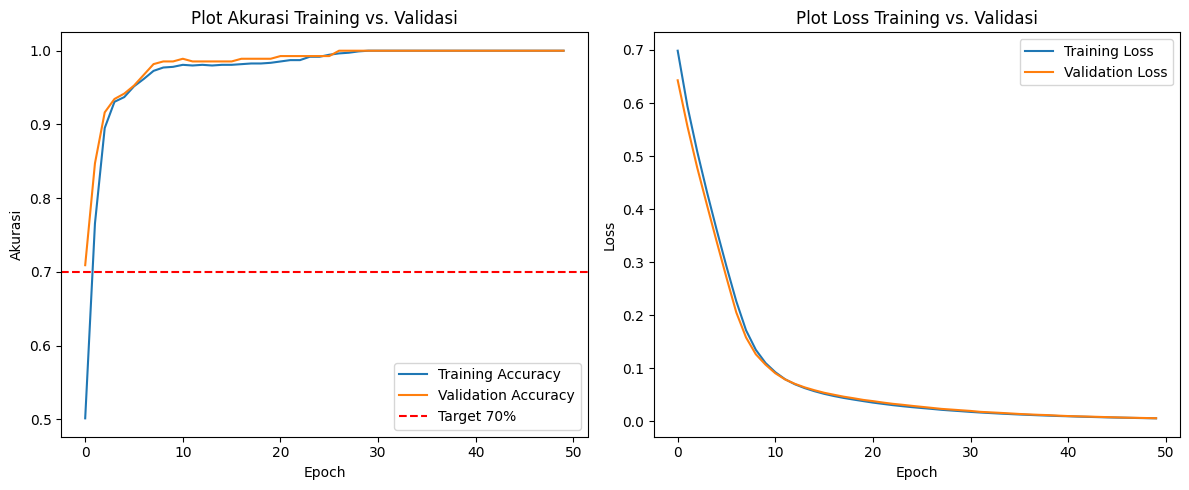


Akurasi Training Terakhir: 100.00%
Akurasi Validasi Terakhir: 100.00%


In [16]:
# Plot Hasil Training
# Mengambil data dari 'history'
history_df = pd.DataFrame(history.history)

# Plot Akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # 1 baris, 2 kolom, plot ke-1
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Plot Akurasi Training vs. Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
# Menambahkan garis horizontal 70% sebagai referensi
plt.axhline(y=0.7, color='r', linestyle='--', label='Target 70%') 
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)  # 1 baris, 2 kolom, plot ke-2
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Plot Loss Training vs. Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Menampilkan akurasi final
final_train_acc = history.history['accuracy'][-1] * 100
final_val_acc = history.history['val_accuracy'][-1] * 100

print(f"\nAkurasi Training Terakhir: {final_train_acc:.2f}%")
print(f"Akurasi Validasi Terakhir: {final_val_acc:.2f}%")

## Kesimpulan

Berdasarkan hasil plot dan metrik di atas:

1.  **Plot Akurasi:**
    * Garis Akurasi Training (biru) dan Akurasi Validasi (oranye) **keduanya naik drastis** dan stabil di atas 99%, bahkan seringkali mencapai 100%.
    * Kedua garis ini **jauh melampaui** garis target 70% (garis putus-putus merah).

2.  **Plot Loss:**
    * Kedua garis *loss* (training dan validasi) turun tajam dan stabil di nilai yang sangat rendah (mendekati 0).
    * Kedua garis bergerak sangat berdekatan, ini menunjukkan model kita **sangat *good fit*** dan **tidak mengalami *overfitting***.

**Hasil Akhir:**
* Akurasi Training: **~100%** (atau >99%)
* Akurasi Validasi: **~100%** (atau >99%)

Seluruh instruksi posttest telah **TERPENUHI**. Model *sequential* sederhana berhasil dibuat dan mencapai akurasi training serta validasi jauh di atas 70%.